<a href="https://colab.research.google.com/github/toby-j/NLP-Experiments-on-GoEmotions-dataset/blob/main/N_Grams_(Ex_4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Loading

In [57]:
try:
  !pip install datasets
  !pip install transformers
  !pip install language-tool-python
  !pip install contractions
except:
  import locale
  locale.getpreferredencoding = lambda: "UTF-8"
  !pip install datasets
  !pip install transformers
  !pip install language-tool-python
  !pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from numpy import *
import numpy as np

# nltk
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

# Spelling imports
import re
import spacy
import language_tool_python
import spacy
import contractions
from language_tool_python import LanguageTool


from collections import defaultdict, Counter

# Huggingface
from transformers import TFBertForSequenceClassification, AutoTokenizer, BertTokenizer
from datasets import Dataset, load_dataset, concatenate_datasets, DatasetDict

#Metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Classnames

In [59]:
raw_dataset = load_dataset("go_emotions")

  0%|          | 0/3 [00:00<?, ?it/s]

In [60]:
{'0': 'admiration',
 '1': 'amusement',
 '2': 'anger',
 '3': 'annoyance',
 '4': 'approval',
 '5': 'caring',
 '6': 'confusion',
 '7': 'curiosity',
 '8': 'desire',
 '9': 'disappointment',
 '10': 'disapproval',
 '11': 'disgust',
 '12': 'embarrassment',
 '13': 'excitement',
 '14': 'fear',
 '15': 'gratitude',
 '16': 'grief',
 '17': 'joy',
 '18': 'love',
 '19': 'nervousness',
 '20': 'optimism',
 '21': 'pride',
 '22': 'realization',
 '23': 'relief',
 '24': 'remorse',
 '25': 'sadness',
 '26': 'surprise',
 '27': 'neutral'}

all_class_names = [
    "admiration",
    "amusement",
    "anger",
    "annoyance",
    "approval",
    "caring",
    "confusion",
    "curiosity",
    "desire",
    "disappointment",
    "disapproval",
    "disgust",
    "embarrassment",
    "excitement",
    "fear",
    "gratitude",
    "grief",
    "joy",
    "love",
    "nervousness",
    "optimism",
    "pride",
    "realization",
    "relief",
    "remorse",
    "sadness",
    "surprise",
    "neutral",
]

# Global Functions

## Display

In [61]:
def plot_graphs(vals, name, y_lim = 99999, y_scale = "linear", legend = []):
  """
  vals : list[list]
    a list of (a list of values for each epoch) - default expects [train values, test values]
  name : str
    name of type of values (goes on y-axis) eg "loss", "accuracy"
  y_lim : int
    greatest value on y axis is min(y_lim, max value in vals)
  y_scale : str
    controls scale of y-axis eg "linear", "logarithmic
  legend : list[str]
    allows for a custom legend
  """
  for val in vals:
    plt.plot(val)

  plt.ylabel(name)
  plt.xlabel("epoch")
  plt.xlim(0, len(vals[0]) - 1)
  if y_scale == "linear":
    plt.ylim(min(0, array(vals).min()), min(y_lim, array(vals).max()))
  plt.yscale(y_scale)

  if len(legend) > 0:
    plt.legend(legend)
  else:
    plt.legend(["train", "test"])

  plt.show()

  print(['{:.2e}'.format(v[-1]) for v in vals])

In [62]:
def output_metrics(model, test_data, test_labels):
  predictions = model.predict(test_data)

  y_pred  = np.argmax(predictions, axis=-1)
  y_test = np.argmax(test_labels, axis=-1)

  print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
  print(f'F1 score: {f1_score(y_test, y_pred, average="weighted")}')
  print(f'Precision score: {precision_score(y_test, y_pred, average="weighted")}')
  print(f'Recall score: {recall_score(y_test, y_pred, average="weighted")}')

In [63]:
# Plot low, med, high spelling corrections based on Levenshtein distance
def plot_corrections(corrections):
    labels = list(corrections.keys())
    values = [len(corrections[label]) for label in labels]
    plt.bar(labels, values)
    plt.xlabel('Edit Distance Category')
    plt.ylabel('Number of Corrections')
    plt.title('Correction Counts by Edit Distance Category')
    plt.show()

In [64]:
from sklearn import metrics

def plot_confusion_matrix(model_input, test_data, test_labels):
  predictions = model_input.predict(test_data)

  y_pred  = np.argmax(predictions, axis=-1)
  y_test = np.argmax(test_labels, axis=-1)

  confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

  labels = list(set(y_test) | set(y_pred))
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)

  fig, ax = plt.subplots(figsize=(10, 8))
  cm_display.plot(ax=ax)


  plt.show()

In [65]:
def get_top_ngram_words(dataset, n, top_k):
    ngram_counter = Counter()
    word_counter = Counter()
    for sample in dataset:
        sample = generate_ngrams(sample, n)
        tokens = nltk.word_tokenize(sample['text'])
        ngrams = nltk.ngrams(tokens, n)
        ngram_counter.update(ngrams)
        word_counter.update(tokens)

    top_ngrams = ngram_counter.most_common(top_k)
    top_words = [word for word, count in word_counter.most_common() if word not in top_ngrams][:top_k]
    word_freqs = {word: count for word, count in word_counter.items() if word in top_words}
    return word_freqs

## Utility

Functions shared across all experiments.

In [66]:
def tokenize_dataset(data):
    # Keys of the returned dictionary will be added to the dataset as columns
    tokenizer_out = tokenizer(data["text"], padding = "max_length", truncation = True, max_length = seq_len) # Sets length of tokenized string to mean token sequence length
    for key in tokenizer_out:
      data[key] = tokenizer_out[key]
    return data

In [67]:
def generate_ngrams(sample, n):
    tokens = nltk.word_tokenize(sample['text'])
    ngrams = nltk.ngrams(tokens, n)
    ngram_text = [' '.join(ngram) for ngram in ngrams]
    sample['text'] = ' '.join(ngram_text)
    return sample

## Variables
Variables that are shared across all experiments.

In [68]:
#Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

## Levenshtein Distance Algorithm
This algorithm measures how different two words are. This based on the number of characters needed to be altered.

To visualise how the changes of each experiment are different from each other, I use this algorithm to calculate low, medium and high edit distances of words that Hunspell corrects.

The more low edit distances that are made, the more likely the correction that Hunspell made was indeed correct. Therefore, we're looking at minimising medium and high edit distances.

In [69]:
def levenshtein_distance(s, t):
    # Normalise lengths
    m, n = len(s), len(t)
    if m < n:
        # if length of t is greater s, swap them round.
        return levenshtein_distance(t, s)
    if n == 0:
        return m
    previous_row = range(n + 1)
    for i, c1 in enumerate(s):
        current_row = [i + 1]
        for j, c2 in enumerate(t):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

# Introduction

This notebook is a pre-processing experiment, which introduces spell-checking on a standardised control model trained on the GoEmotions dataset. As as group we developed the control model to ensure an accurate and trustworthy comparson of results from each of our experiments.





    

    

    


# Control

## Dataset Preparation
The following section describes the standardised way in which the dataset is prepared for training. These steps include the filtering of classes to ensure the dataset only includes the required 14. The prepartaion of the dataset has been controlled (kept the same) for each experiment to enable accurate and fair measuring of the results yielded by the modified variable in each experiment.

{'grief': 77, 'pride': 111, 'relief': 153, 'nervousness': 164, 'embarrassment': 303, 'remorse': 545, 'fear': 596, 'desire': 641, 'disgust': 793, 'excitement': 853, 'surprise': 1060, 'caring': 1087, 'realization': 1110, 'disappointment': 1269, 'sadness': 1326, 'confusion': 1368, 'joy': 1452, 'anger': 1567, 'optimism': 1581, 'disapproval': 2022, 'love': 2086, 'curiosity': 2191, 'amusement': 2328, 'annoyance': 2470, 'gratitude': 2662, 'approval': 2939, 'admiration': 4130, 'neutral': 14219}


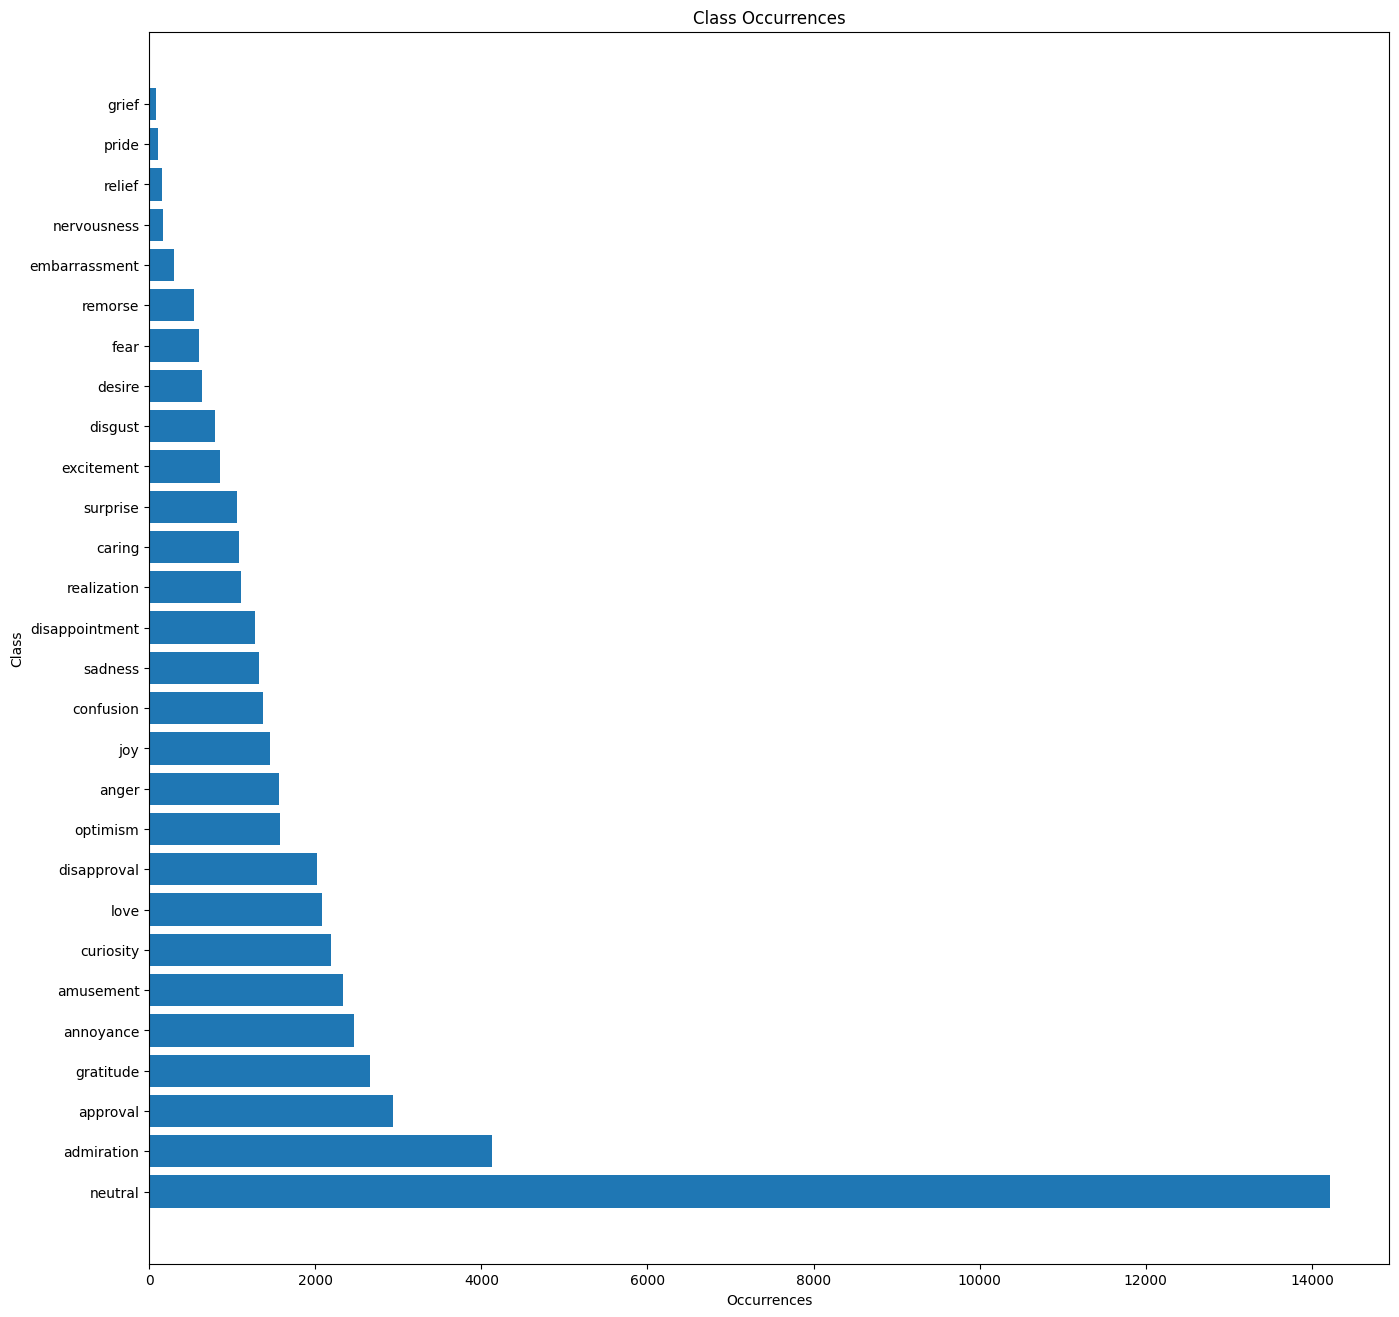

In [70]:
def count_classes(class_names):
    class_counts = {class_name: 0 for class_name in class_names}

    for item in raw_dataset['train']:
      for class_name in item['labels']:
            class_counts[all_class_names[class_name]] += 1
    return class_counts

feature_distribution = dict(sorted(count_classes(all_class_names).items(), key=lambda item: item[1])) 

print(feature_distribution)

def plot_class_occurrences(class_counts):
    # Get the class names and occurrence counts
    class_names = list(class_counts.keys())
    class_counts = list(class_counts.values())

    # Create a horizontal bar chart
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.barh(class_names, class_counts)

    # Set the axis labels and title
    ax.set_xlabel('Occurrences')
    ax.set_ylabel('Class')
    ax.set_title('Class Occurrences')

    # Invert the y-axis to show the classes in descending order of occurrences
    ax.invert_yaxis()

    # Show the plot
    plt.show()

plot_class_occurrences(feature_distribution)

In [71]:
# Get top 14 most frequently occuring keys in dataset and fetch their indices
class_names = list(feature_distribution.keys())[-14:]
class_name_idxs = [all_class_names.index(x) for x in class_names]
print(list(zip(class_names, class_name_idxs)))

[('sadness', 25), ('confusion', 6), ('joy', 17), ('anger', 2), ('optimism', 20), ('disapproval', 10), ('love', 18), ('curiosity', 7), ('amusement', 1), ('annoyance', 3), ('gratitude', 15), ('approval', 4), ('admiration', 0), ('neutral', 27)]


In [72]:
# Here's the indexs of our selected classes
print(class_name_idxs)

[25, 6, 17, 2, 20, 10, 18, 7, 1, 3, 15, 4, 0, 27]


## Filtering

We'll now filter the dataset so it only contains the classes we're interested in

In [73]:
def flatten_list(arr):
  return [num for sublist in arr for num in sublist]

In [74]:
# If it has at least one label that is the selected subset of classes it's valid
def is_valid(data_item):
  return not (len(data_item["labels"]) == 1 and data_item["labels"][0] not in class_name_idxs)

# Remove classes that don't have a label in our 14 selected classes 
def remove_invalid_classes(data_item):
  data_item["labels"] = [label for label in data_item["labels"] if label in class_name_idxs] 

  for label in data_item["labels"]:
    assert label in class_name_idxs

  data_item["labels"] = [class_name_idxs.index(label) for label in data_item["labels"]][0:1] # "Rename" old labels

  return data_item

def one_hot_labels(data_item):
  data_item["labels"] = sum(to_categorical(data_item["labels"], len(class_name_idxs)), axis = 0)
  return data_item

# Apply dataset processing
dataset = raw_dataset.filter(lambda x: is_valid(x)).map(remove_invalid_classes)

# One-hot the labels
dataset_control = dataset.map(one_hot_labels)

Map:   0%|          | 0/38100 [00:00<?, ? examples/s]

Map:   0%|          | 0/4756 [00:00<?, ? examples/s]

Map:   0%|          | 0/4728 [00:00<?, ? examples/s]

## Tokenisation

In [75]:
seq_lens = [len(tokenizer(x)["input_ids"]) for x in dataset_control["train"]["text"]]

seq_len = int(ceil(mean(seq_lens) + std(seq_lens)))

dataset_tokenized = dataset_control.map(tokenize_dataset)

Map:   0%|          | 0/38100 [00:00<?, ? examples/s]

Map:   0%|          | 0/4756 [00:00<?, ? examples/s]

Map:   0%|          | 0/4728 [00:00<?, ? examples/s]

## Model Definition
In this experiment. We are not changing the model, so both utilise this definition.

In [76]:
# Resets TF graph to release memory
tf.keras.backend.clear_session()

def define_model():
  input_ids = Input(shape = (seq_len,), dtype = "int32", name = "input_ids")
  token_type_ids = Input(shape = (seq_len,), dtype = "int32", name = "token_type_ids")
  attention_masks = Input(shape = (seq_len,), dtype = "int32", name = "attention_mask")

  bert = TFBertForSequenceClassification.from_pretrained("bert-base-cased", num_labels = 14)

  inputs = {"input_ids": input_ids, "attention_mask": attention_masks, "token_type_ids": token_type_ids}
  outputs = bert(inputs)
  model = outputs.logits
  
  model = Dense(14, activation = "softmax")(model)

  model = Model(inputs = [input_ids, token_type_ids, attention_masks], outputs = model)

  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

  model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

  return model

define_model().summary()

model = define_model()

early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 8, restore_best_weights = True)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  108321038  ['attention_mask[0][0]',         
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'input_ids[0][0]',          

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [77]:
model = define_model()

batch_size = 128

def create_test_dataset(ds):
  return ds["test"].to_tf_dataset( # 1000 for speed debugging, for full training, comment out the ".select(n)"
  columns = ["input_ids", "token_type_ids", "attention_mask"],
  label_cols = ["labels"],
  batch_size = batch_size,
  shuffle = True,
)
  
def create_train_dataset(ds):
  return ds["train"].to_tf_dataset( # 1000 for speed debugging, for full training, comment out the ".select(n)"
  columns = ["input_ids", "token_type_ids", "attention_mask"],
  label_cols = ["labels"],
  batch_size = batch_size,
  shuffle = True,
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Control Training

In [78]:
control_tf_test_dataset = create_test_dataset(dataset_tokenized)
control_tf_train_dataset = create_train_dataset(dataset_tokenized)

# Create a variable to use for our metrics for our display functions. This is used by all experiments.
control_test_display_item = list(control_tf_test_dataset)[1]
control_test_data, control_test_labels = control_test_display_item

control_history = model.fit(control_tf_train_dataset, validation_data = control_tf_test_dataset , epochs = 40, callbacks = [early_stopping]).history

Epoch 1/40
298/298 [==============================] - 91s 160ms/step - loss: 1.4274 - accuracy: 0.5671 - val_loss: 1.2070 - val_accuracy: 0.6146
Epoch 2/40
298/298 [==============================] - 33s 112ms/step - loss: 1.0466 - accuracy: 0.6581 - val_loss: 1.1349 - val_accuracy: 0.6286
Epoch 3/40
298/298 [==============================] - 30s 99ms/step - loss: 0.8046 - accuracy: 0.7326 - val_loss: 1.2425 - val_accuracy: 0.6030
Epoch 4/40
298/298 [==============================] - 29s 98ms/step - loss: 0.5681 - accuracy: 0.8091 - val_loss: 1.4036 - val_accuracy: 0.5886
Epoch 5/40
298/298 [==============================] - 29s 99ms/step - loss: 0.3665 - accuracy: 0.8775 - val_loss: 1.6107 - val_accuracy: 0.5861
Epoch 6/40
298/298 [==============================] - 29s 98ms/step - loss: 0.2565 - accuracy: 0.9118 - val_loss: 1.8206 - val_accuracy: 0.5732
Epoch 7/40
298/298 [==============================] - 29s 98ms/step - loss: 0.2050 - accuracy: 0.9293 - val_loss: 1.8462 - val_accurac

## Metrics

4/4 [==============================] - 2s 10ms/step
Accuracy score: 0.578125
F1 score: 0.5497420130470816
Precision score: 0.5891290133477632
Recall score: 0.578125
4/4 [==============================] - 0s 10ms/step


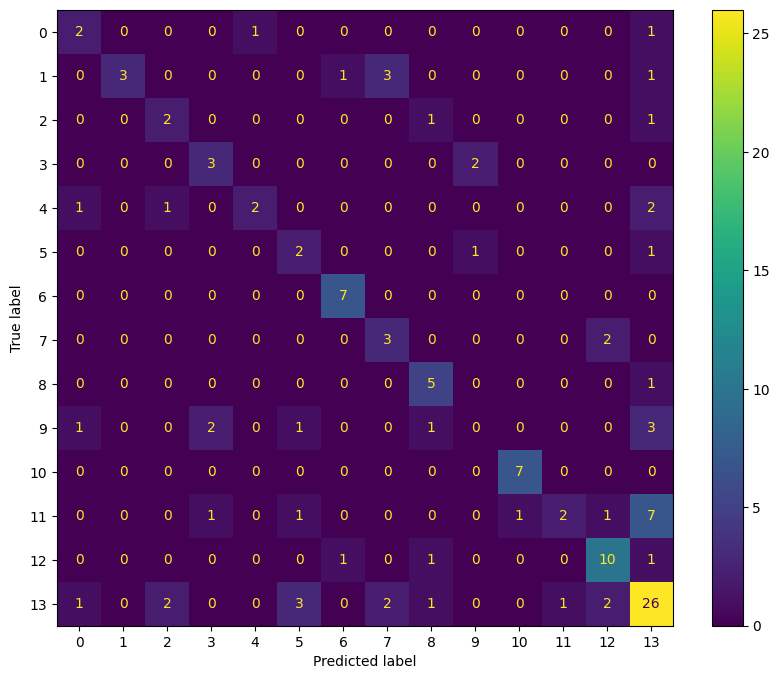

In [79]:
output_metrics(model, control_test_data, control_test_labels)
plot_confusion_matrix(model, control_test_data, control_test_labels)

# Experiment 4.0: Bi-Grams

---

## Preparation

In [80]:
# We take a copy of the dataset that we processed earlier before tokenisation is applied.
dataset_4 = dataset_control.copy()

In [81]:
dataset_4 = DatasetDict(dataset_4)

In [82]:
bigrams_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

## Bi-Grams

In [83]:
experiment_4_bigrams = dataset_4['train'].map(lambda sample: generate_ngrams(sample, 2))

Map:   0%|          | 0/38100 [00:00<?, ? examples/s]

In [84]:
for i in range(100):
  print(experiment_4_bigrams['text'][i])

My favourite favourite food food is is anything anything I I did did n't n't have have to to cook cook myself myself .
Now if if he he does does off off himself himself , , everyone everyone will will think think hes hes having having a a laugh laugh screwing screwing with with people people instead instead of of actually actually dead
WHY THE THE FUCK FUCK IS IS BAYLESS BAYLESS ISOING
Dirty Southern Southern Wankers
Yes I I heard heard abt abt the the f f bombs bombs ! ! That That has has to to be be why why . . Thanks Thanks for for your your reply reply : : ) ) until until then then hubby hubby and and I I will will anxiously anxiously wait wait 😝
We need need more more boards boards and and to to create create a a bit bit more more space space for for [ [ NAME NAME ] ] . . Then Then we we ’ ’ ll ll be be good good .
Damn youtube youtube and and outrage outrage drama drama is is super super lucrative lucrative for for reddit
It might might be be linked linked to to the the trust tru

In [85]:
dataset_4['train'] = experiment_4_bigrams

## Tokenization

In [86]:
experiment_4_tokenized = dataset_4.map(tokenize_dataset)

Map:   0%|          | 0/38100 [00:00<?, ? examples/s]

## Training

In [87]:
# Train the model with default learning rate
experiment_4_tf_test_dataset = create_test_dataset(experiment_4_tokenized)
experiment_4_tf_train_dataset = create_train_dataset(experiment_4_tokenized)

# Create a variable to use for our metrics for our display functions. This is used by all experiments.
experiment_4_test_display_item = list(experiment_4_tf_test_dataset)[0]
experiment_4_test_data, experiment_4_test_labels = experiment_4_test_display_item

experiment_4_history = model.fit(experiment_4_tf_train_dataset, validation_data = experiment_4_tf_test_dataset , epochs = 40, callbacks = [early_stopping]).history

Epoch 1/40
298/298 [==============================] - 47s 157ms/step - loss: 1.1097 - accuracy: 0.6629 - val_loss: 1.2031 - val_accuracy: 0.6108
Epoch 2/40
298/298 [==============================] - 31s 103ms/step - loss: 0.8472 - accuracy: 0.7380 - val_loss: 1.2815 - val_accuracy: 0.6026
Epoch 3/40
298/298 [==============================] - 29s 99ms/step - loss: 0.5758 - accuracy: 0.8171 - val_loss: 1.5926 - val_accuracy: 0.5812
Epoch 4/40
298/298 [==============================] - 30s 100ms/step - loss: 0.3897 - accuracy: 0.8743 - val_loss: 1.6995 - val_accuracy: 0.5740
Epoch 5/40
298/298 [==============================] - 29s 96ms/step - loss: 0.2574 - accuracy: 0.9139 - val_loss: 1.9017 - val_accuracy: 0.5916
Epoch 6/40
298/298 [==============================] - 30s 101ms/step - loss: 0.1949 - accuracy: 0.9334 - val_loss: 2.0686 - val_accuracy: 0.5527
Epoch 7/40
298/298 [==============================] - 29s 97ms/step - loss: 0.1527 - accuracy: 0.9451 - val_loss: 2.1020 - val_accur

## Metrics

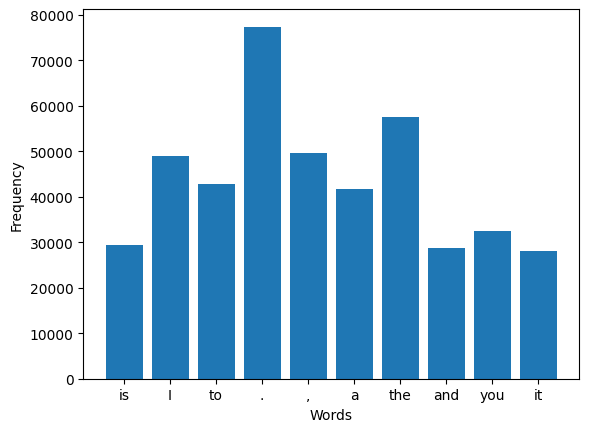

In [88]:
top_words = get_top_ngram_words(dataset_4['train'], 2, 10)

plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [89]:
print(top_words)

{'is': 29431, 'I': 48979, 'to': 42739, '.': 77418, ',': 49737, 'a': 41639, 'the': 57564, 'and': 28860, 'you': 32539, 'it': 28132}


4/4 [==============================] - 0s 10ms/step
Accuracy score: 0.65625
F1 score: 0.6595945978257236
Precision score: 0.6778244786389733
Recall score: 0.65625
4/4 [==============================] - 0s 10ms/step


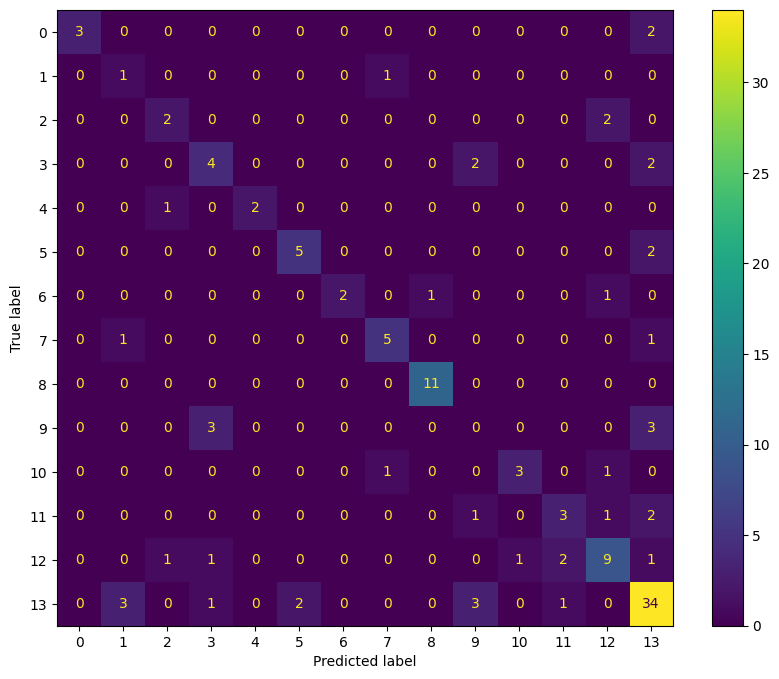

In [90]:
output_metrics(model, experiment_4_test_data, experiment_4_test_labels)
plot_confusion_matrix(model, experiment_4_test_data, experiment_4_test_labels)

# Experiment 4.1: Tri-grams

## Preparation

In [91]:
# Make another copy to use for 1.1
dataset_4_1 = dataset_control.copy()

In [92]:
for i in range(10):
  print(dataset_4_1['train']['text'][i])

My favourite food is anything I didn't have to cook myself.
Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
WHY THE FUCK IS BAYLESS ISOING
Dirty Southern Wankers
Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝
We need more boards and to create a bit more space for [NAME]. Then we’ll be good.
Damn youtube and outrage drama is super lucrative for reddit
It might be linked to the trust factor of your friend.
Demographics? I don’t know anybody under 35 who has cable tv.
Aww... she'll probably come around eventually, I'm sure she was just jealous of [NAME]... I mean, what woman wouldn't be! lol 


## Tri-grams

In [93]:
experiment_4_1_bigrams = dataset_4_1['train'].map(lambda sample: generate_ngrams(sample, 3))

Map:   0%|          | 0/38100 [00:00<?, ? examples/s]

In [94]:
for i in range(100):
  print(experiment_4_1_bigrams['text'][i])

My favourite food favourite food is food is anything is anything I anything I did I did n't did n't have n't have to have to cook to cook myself cook myself .
Now if he if he does he does off does off himself off himself , himself , everyone , everyone will everyone will think will think hes think hes having hes having a having a laugh a laugh screwing laugh screwing with screwing with people with people instead people instead of instead of actually of actually dead
WHY THE FUCK THE FUCK IS FUCK IS BAYLESS IS BAYLESS ISOING
Dirty Southern Wankers
Yes I heard I heard abt heard abt the abt the f the f bombs f bombs ! bombs ! That ! That has That has to has to be to be why be why . why . Thanks . Thanks for Thanks for your for your reply your reply : reply : ) : ) until ) until then until then hubby then hubby and hubby and I and I will I will anxiously will anxiously wait anxiously wait 😝
We need more need more boards more boards and boards and to and to create to create a create a bit a

In [95]:
dataset_4_1['train'] = experiment_4_1_bigrams

In [96]:
dataset_4_1 = DatasetDict(dataset_4_1)

## Tokenization

In [97]:
experiment_4_1_tokenized = dataset_4_1.map(tokenize_dataset)

Map:   0%|          | 0/38100 [00:00<?, ? examples/s]

## Training

In [98]:
experiment_4_1_tf_test_dataset = create_test_dataset(experiment_4_1_tokenized)
experiment_4_1_tf_train_dataset = create_train_dataset(experiment_4_1_tokenized)

# Create a variable to use for our metrics for our display functions. This is used by all experiments.
experiment_4_1_test_display_item = list(experiment_4_1_tf_test_dataset)[1]
experiment_4_1_test_data, experiment_4_1_test_labels = experiment_4_1_test_display_item

early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 8, restore_best_weights = True)
experiment_4_1_history = model.fit(create_train_dataset(experiment_4_1_tokenized), validation_data = create_test_dataset(experiment_4_1_tokenized), epochs = 40, callbacks = [early_stopping]).history

Epoch 1/40
298/298 [==============================] - 43s 142ms/step - loss: 1.0843 - accuracy: 0.6717 - val_loss: 1.2917 - val_accuracy: 0.6055
Epoch 2/40
298/298 [==============================] - 30s 100ms/step - loss: 0.7980 - accuracy: 0.7547 - val_loss: 1.5336 - val_accuracy: 0.5901
Epoch 3/40
298/298 [==============================] - 29s 98ms/step - loss: 0.5227 - accuracy: 0.8339 - val_loss: 1.7673 - val_accuracy: 0.5808
Epoch 4/40
298/298 [==============================] - 29s 96ms/step - loss: 0.3535 - accuracy: 0.8850 - val_loss: 1.8276 - val_accuracy: 0.5766
Epoch 5/40
298/298 [==============================] - 29s 98ms/step - loss: 0.2424 - accuracy: 0.9183 - val_loss: 1.9902 - val_accuracy: 0.5725
Epoch 6/40
298/298 [==============================] - 29s 98ms/step - loss: 0.1756 - accuracy: 0.9386 - val_loss: 2.0984 - val_accuracy: 0.5658
Epoch 7/40
298/298 [==============================] - 29s 96ms/step - loss: 0.1397 - accuracy: 0.9501 - val_loss: 2.2308 - val_accurac

## Metrics

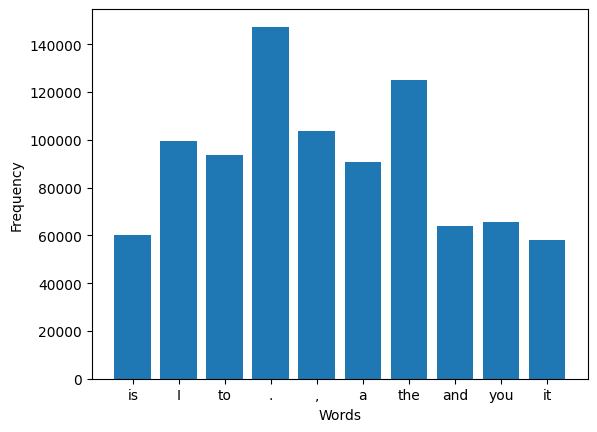

In [99]:
top_words = get_top_ngram_words(dataset_4_1['train'], 3, 10)

plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [100]:
print(top_words)

{'is': 60190, 'I': 99482, 'to': 93679, '.': 147367, ',': 103896, 'a': 90777, 'the': 125024, 'and': 63826, 'you': 65713, 'it': 57884}


4/4 [==============================] - 0s 10ms/step
Accuracy score: 0.5859375
F1 score: 0.567727184184677
Precision score: 0.6057393127705628
Recall score: 0.5859375
4/4 [==============================] - 0s 10ms/step


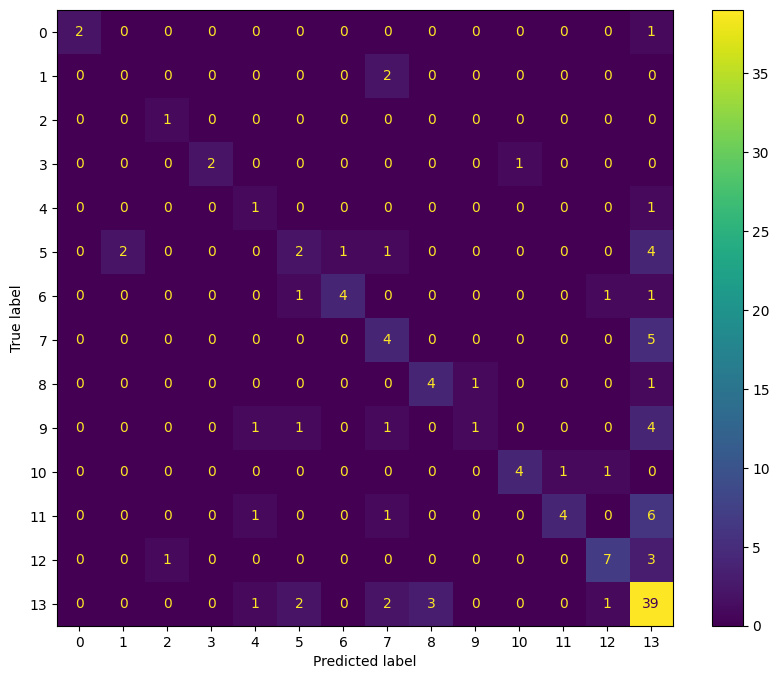

In [101]:
output_metrics(model, experiment_4_1_test_data, experiment_4_1_test_labels)
plot_confusion_matrix(model, experiment_4_1_test_data, experiment_4_1_test_labels)

# Experiment 4.2: Removing stopwords -> Bi-grams
---






## Preparation

In [102]:
# Make another copy to use for 1.1
dataset_4_2 = dataset_control.copy()

In [103]:
for i in range(10):
  print(dataset_4_2['train']['text'][i])

My favourite food is anything I didn't have to cook myself.
Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
WHY THE FUCK IS BAYLESS ISOING
Dirty Southern Wankers
Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝
We need more boards and to create a bit more space for [NAME]. Then we’ll be good.
Damn youtube and outrage drama is super lucrative for reddit
It might be linked to the trust factor of your friend.
Demographics? I don’t know anybody under 35 who has cable tv.
Aww... she'll probably come around eventually, I'm sure she was just jealous of [NAME]... I mean, what woman wouldn't be! lol 


## Removing stop-words

In [104]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = text['text'].split()
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    text['text'] = ' '.join(filtered_tokens)
    return text

In [105]:
removed_stopwords = dataset_4_2['train'].map(remove_stopwords)

Map:   0%|          | 0/38100 [00:00<?, ? examples/s]

In [106]:
dataset_4_2['train'] = removed_stopwords

## Bi-grams

In [107]:
experiment_4_2_bigrams = dataset_4_2['train'].map(lambda sample: generate_ngrams(sample, 2))

Map:   0%|          | 0/38100 [00:00<?, ? examples/s]

In [108]:
for i in range(100):
  print(experiment_4_2_bigrams['text'][i])

favourite food food anything anything cook cook myself myself .
himself , , everyone everyone think think hes hes laugh laugh screwing screwing people people instead instead actually actually dead
FUCK BAYLESS BAYLESS ISOING
Dirty Southern Southern Wankers
Yes heard heard abt abt f f bombs bombs ! ! why why . . Thanks Thanks reply reply : : ) ) hubby hubby anxiously anxiously wait wait 😝
need boards boards create create bit bit space space [ [ NAME NAME ] ] . . we we ’ ’ ll ll good good .
Damn youtube youtube outrage outrage drama drama super super lucrative lucrative reddit
might linked linked trust trust factor factor friend friend .
Demographics ? ? don don ’ ’ t t know know anybody anybody 35 35 cable cable tv tv .
Aww ... ... she she 'll 'll probably probably come come around around eventually eventually , , I I 'm 'm sure sure jealous jealous [ [ NAME NAME ] ] ... ... mean mean , , woman woman be be ! ! lol
Hello everyone everyone . . Im Im Toronto Toronto well well . . call call

In [109]:
dataset_4_2['train'] = experiment_4_2_bigrams

In [110]:
dataset_4_2 = DatasetDict(dataset_4_2)

## Tokenization

In [111]:
experiment_4_2_tokenized = dataset_4_2.map(tokenize_dataset)

Map:   0%|          | 0/38100 [00:00<?, ? examples/s]

## Training

In [112]:
experiment_4_2_tf_test_dataset = create_test_dataset(experiment_4_2_tokenized)
experiment_4_2_tf_train_dataset = create_train_dataset(experiment_4_2_tokenized)

# Create a variable to use for our metrics for our display functions. This is used by all experiments.
experiment_4_2_test_display_item = list(experiment_4_2_tf_test_dataset)[1]
experiment_4_2_test_data, experiment_4_2_test_labels = experiment_4_2_test_display_item

experiment_4_2_history = model.fit(create_train_dataset(experiment_4_2_tokenized), validation_data = create_test_dataset(experiment_4_2_tokenized), epochs = 40, callbacks = [early_stopping]).history

Epoch 1/40
298/298 [==============================] - 31s 105ms/step - loss: 0.9665 - accuracy: 0.6932 - val_loss: 1.2381 - val_accuracy: 0.5981
Epoch 2/40
298/298 [==============================] - 30s 99ms/step - loss: 0.6226 - accuracy: 0.7985 - val_loss: 1.3535 - val_accuracy: 0.5950
Epoch 3/40
298/298 [==============================] - 29s 98ms/step - loss: 0.3867 - accuracy: 0.8730 - val_loss: 1.6418 - val_accuracy: 0.5666
Epoch 4/40
298/298 [==============================] - 29s 97ms/step - loss: 0.2673 - accuracy: 0.9113 - val_loss: 1.7286 - val_accuracy: 0.5717
Epoch 5/40
298/298 [==============================] - 29s 97ms/step - loss: 0.2069 - accuracy: 0.9283 - val_loss: 1.9543 - val_accuracy: 0.5719
Epoch 6/40
298/298 [==============================] - 29s 98ms/step - loss: 0.1677 - accuracy: 0.9422 - val_loss: 2.0837 - val_accuracy: 0.5778
Epoch 7/40
298/298 [==============================] - 29s 97ms/step - loss: 0.1413 - accuracy: 0.9503 - val_loss: 2.0971 - val_accuracy

## Metrics

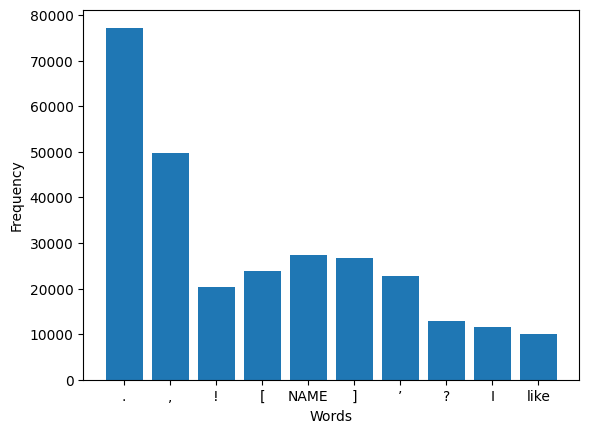

In [113]:
top_words = get_top_ngram_words(dataset_4_2['train'], 2, 10)

plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

4/4 [==============================] - 0s 10ms/step
Accuracy score: 0.5625
F1 score: 0.5551237671642083
Precision score: 0.605218916303822
Recall score: 0.5625
4/4 [==============================] - 0s 10ms/step


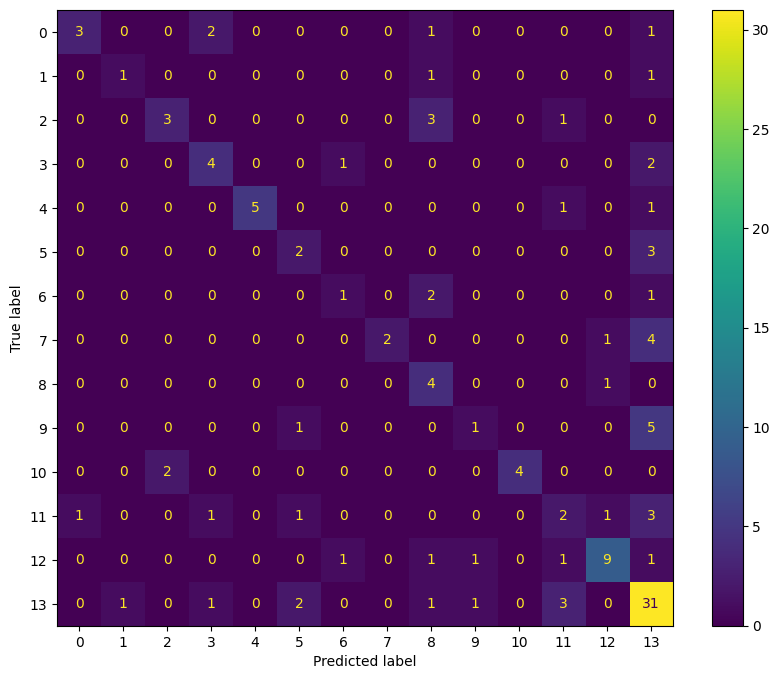

In [114]:
output_metrics(model, experiment_4_2_test_data, experiment_4_2_test_labels)
plot_confusion_matrix(model, experiment_4_2_test_data, experiment_4_2_test_labels)

# Experiment 4.3: Lemmitization -> bi-grams

## Preparation

In [115]:
dataset_4_3 = dataset_control.copy()

## Remove stop words

In [116]:
def lemmatize(example):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(example['text'])
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    example['text'] = ' '.join(lemmatized_words)
    return example

In [117]:
train_lemmatized = dataset_4_3['train'].map(lemmatize)

Map:   0%|          | 0/38100 [00:00<?, ? examples/s]

In [118]:
dataset_4_3['train'] = train_lemmatized

In [119]:
for i in range(100):
  print(dataset_4_3['train']['text'][i])

My favourite food is anything I did n't have to cook myself .
Now if he doe off himself , everyone will think he having a laugh screwing with people instead of actually dead
WHY THE FUCK IS BAYLESS ISOING
Dirty Southern Wankers
Yes I heard abt the f bomb ! That ha to be why . Thanks for your reply : ) until then hubby and I will anxiously wait 😝
We need more board and to create a bit more space for [ NAME ] . Then we ’ ll be good .
Damn youtube and outrage drama is super lucrative for reddit
It might be linked to the trust factor of your friend .
Demographics ? I don ’ t know anybody under 35 who ha cable tv .
Aww ... she 'll probably come around eventually , I 'm sure she wa just jealous of [ NAME ] ... I mean , what woman would n't be ! lol
Hello everyone . Im from Toronto a well . Can call and visit in personal if needed .
[ NAME ] - same fucking problem , slightly better command of the English language .
Shit , I guess I accidentally bought a Pay-Per-View boxing match
Thank you fri

In [120]:
dataset_4_3 = DatasetDict(dataset_4_3)

In [121]:
print(dataset_4_3)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 38100
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 4756
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 4728
    })
})


## Bi-grams

In [122]:
experiment_4_3_bigrams = dataset_4_3['train'].map(lambda sample: generate_ngrams(sample, 2))

Map:   0%|          | 0/38100 [00:00<?, ? examples/s]

In [123]:
for i in range(100):
  print(experiment_4_3_bigrams['text'][i])

My favourite favourite food food is is anything anything I I did did n't n't have have to to cook cook myself myself .
Now if if he he doe doe off off himself himself , , everyone everyone will will think think he he having having a a laugh laugh screwing screwing with with people people instead instead of of actually actually dead
WHY THE THE FUCK FUCK IS IS BAYLESS BAYLESS ISOING
Dirty Southern Southern Wankers
Yes I I heard heard abt abt the the f f bomb bomb ! ! That That ha ha to to be be why why . . Thanks Thanks for for your your reply reply : : ) ) until until then then hubby hubby and and I I will will anxiously anxiously wait wait 😝
We need need more more board board and and to to create create a a bit bit more more space space for for [ [ NAME NAME ] ] . . Then Then we we ’ ’ ll ll be be good good .
Damn youtube youtube and and outrage outrage drama drama is is super super lucrative lucrative for for reddit
It might might be be linked linked to to the the trust trust factor 

In [124]:
dataset_4_3['train'] = experiment_4_3_bigrams

## Tokenization

In [125]:
experiment_4_3_tokenized = dataset_4_3.map(tokenize_dataset)

Map:   0%|          | 0/38100 [00:00<?, ? examples/s]

## Training

In [126]:
experiment_4_3_tf_test_dataset = create_test_dataset(experiment_4_3_tokenized)
experiment_4_3_tf_train_dataset = create_train_dataset(experiment_4_3_tokenized)

# Create a variable to use for our metrics for our display functions. This is used by all experiments.
experiment_4_3_test_display_item = list(experiment_4_3_tf_test_dataset)[1]
experiment_4_3_test_data, experiment_4_3_test_labels = experiment_4_3_test_display_item

early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 8, restore_best_weights = True)
experiment_4_3_history = model.fit(create_train_dataset(experiment_4_3_tokenized), validation_data = create_test_dataset(experiment_4_3_tokenized), epochs = 40, callbacks = [early_stopping]).history

Epoch 1/40
298/298 [==============================] - 30s 99ms/step - loss: 0.6683 - accuracy: 0.7889 - val_loss: 1.4723 - val_accuracy: 0.5916
Epoch 2/40
298/298 [==============================] - 29s 97ms/step - loss: 0.4441 - accuracy: 0.8582 - val_loss: 1.7490 - val_accuracy: 0.5715
Epoch 3/40
298/298 [==============================] - 29s 98ms/step - loss: 0.2703 - accuracy: 0.9097 - val_loss: 1.9214 - val_accuracy: 0.5871
Epoch 4/40
298/298 [==============================] - 29s 97ms/step - loss: 0.2035 - accuracy: 0.9293 - val_loss: 1.8986 - val_accuracy: 0.5871
Epoch 5/40
298/298 [==============================] - 29s 97ms/step - loss: 0.1466 - accuracy: 0.9474 - val_loss: 2.1484 - val_accuracy: 0.5738
Epoch 6/40
298/298 [==============================] - 29s 97ms/step - loss: 0.1323 - accuracy: 0.9510 - val_loss: 2.2126 - val_accuracy: 0.5546
Epoch 7/40
298/298 [==============================] - 29s 97ms/step - loss: 0.1250 - accuracy: 0.9534 - val_loss: 2.2618 - val_accuracy:

## Metrics

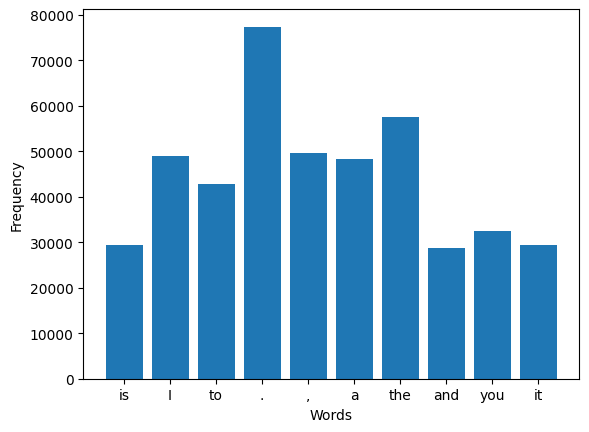

In [127]:
top_words = get_top_ngram_words(dataset_4_3['train'], 2, 10)

plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [128]:
print(top_words)

{'is': 29431, 'I': 48979, 'to': 42739, '.': 77424, ',': 49737, 'a': 48432, 'the': 57564, 'and': 28860, 'you': 32539, 'it': 29496}


4/4 [==============================] - 0s 10ms/step
Accuracy score: 0.484375
F1 score: 0.4755877595218249
Precision score: 0.48435591525774946
Recall score: 0.484375
4/4 [==============================] - 0s 10ms/step


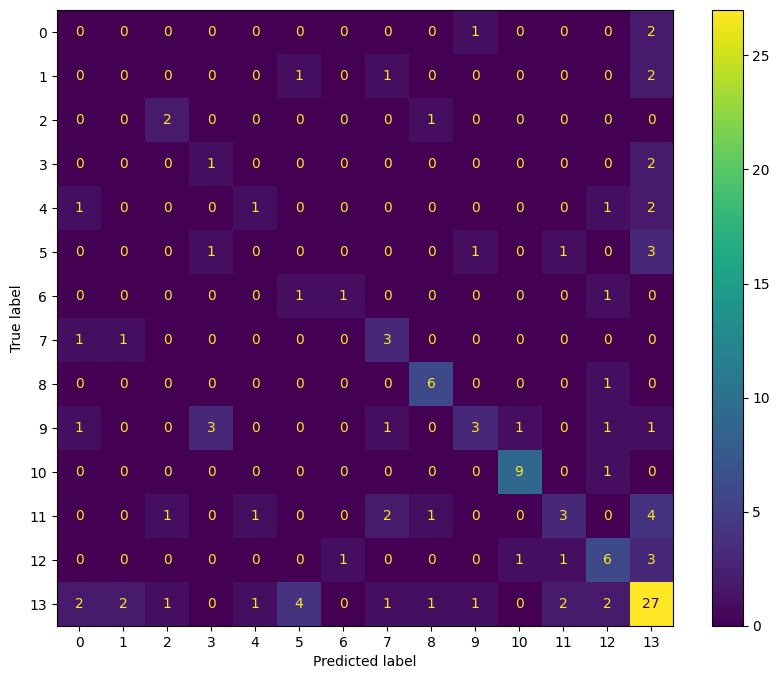

In [129]:
output_metrics(model, experiment_4_3_test_data, experiment_4_3_test_labels)
plot_confusion_matrix(model, experiment_4_3_test_data, experiment_4_3_test_labels)

# Evaluation

## Loss

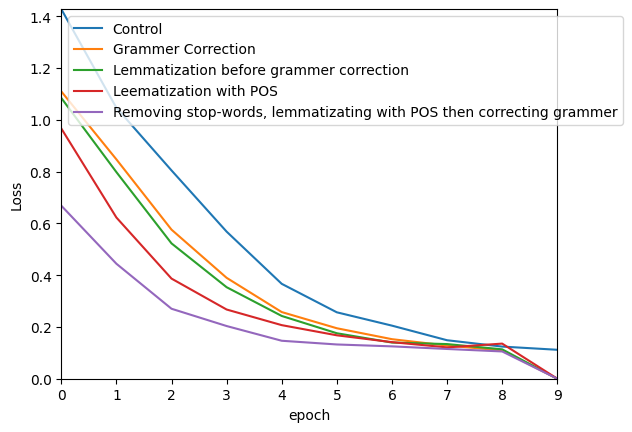

['1.12e-01', '0.00e+00', '0.00e+00', '0.00e+00', '0.00e+00']


In [130]:
control_loss = np.array(control_history["loss"])
experiment_4_loss = np.array(experiment_4_history["loss"])
experiment_4_1_loss = np.array(experiment_4_1_history["loss"])
experiment_4_2_loss = np.array(experiment_4_2_history["loss"])
experiment_4_3_loss = np.array(experiment_4_3_history["loss"])

max_length = max(len(control_loss), len(experiment_4_loss), len(experiment_4_1_loss), len(experiment_4_2_loss), len(experiment_4_3_loss))

control_loss_padded = np.pad(control_loss, (0, max_length - len(control_loss)), mode='constant')
experiment_4_loss_padded = np.pad(experiment_4_loss, (0, max_length - len(experiment_4_loss)), mode='constant')
experiment_4_1_loss_padded = np.pad(experiment_4_1_loss, (0, max_length - len(experiment_4_1_loss)), mode='constant')
experiment_4_2_loss_padded = np.pad(experiment_4_2_loss, (0, max_length - len(experiment_4_2_loss)), mode='constant')
experiment_4_3_loss_padded = np.pad(experiment_4_3_loss, (0, max_length - len(experiment_4_3_loss)), mode='constant')

plot_graphs([control_loss_padded, experiment_4_loss_padded, experiment_4_1_loss_padded, experiment_4_2_loss_padded, experiment_4_3_loss_padded], name="Loss", legend=["Control", "Grammer Correction", "Lemmatization before grammer correction", "Leematization with POS", "Removing stop-words, lemmatizating with POS then correcting grammer"])


## Val Loss

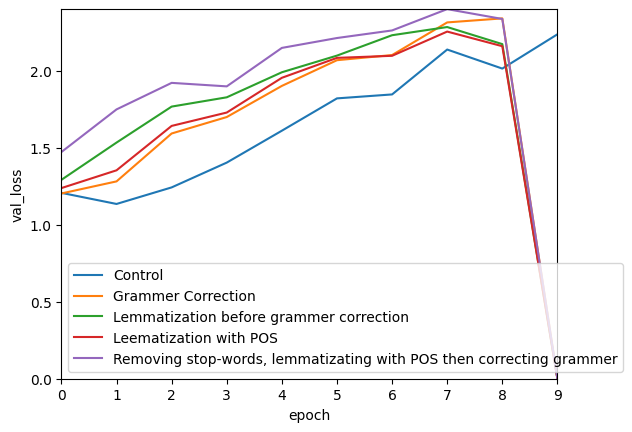

['2.24e+00', '0.00e+00', '0.00e+00', '0.00e+00', '0.00e+00']


In [131]:
control_val_loss = np.array(control_history["val_loss"])
experiment_4_val_loss = np.array(experiment_4_history["val_loss"])
experiment_4_1_val_loss = np.array(experiment_4_1_history["val_loss"])
experiment_4_2_val_loss = np.array(experiment_4_2_history["val_loss"])
experiment_4_3_val_loss = np.array(experiment_4_3_history["val_loss"])

max_length = max(len(control_val_loss), len(experiment_4_val_loss), len(experiment_4_1_val_loss), len(experiment_4_2_val_loss), len(experiment_4_3_val_loss))

control_val_loss_padded = np.pad(control_val_loss, (0, max_length - len(control_val_loss)), mode='constant')
experiment_4_val_loss_padded = np.pad(experiment_4_val_loss, (0, max_length - len(experiment_4_val_loss)), mode='constant')
experiment_4_1_val_loss_padded = np.pad(experiment_4_1_val_loss, (0, max_length - len(experiment_4_1_val_loss)), mode='constant')
experiment_4_2_val_loss_padded = np.pad(experiment_4_2_val_loss, (0, max_length - len(experiment_4_2_val_loss)), mode='constant')
experiment_4_3_val_loss_padded = np.pad(experiment_4_3_val_loss, (0, max_length - len(experiment_4_3_val_loss)), mode='constant')

plot_graphs([control_val_loss_padded, experiment_4_val_loss_padded, experiment_4_1_val_loss_padded, experiment_4_2_val_loss_padded, experiment_4_3_val_loss_padded], name="val_loss", legend=["Control", "Grammer Correction", "Lemmatization before grammer correction", "Leematization with POS", "Removing stop-words, lemmatizating with POS then correcting grammer"])


## Accuracy

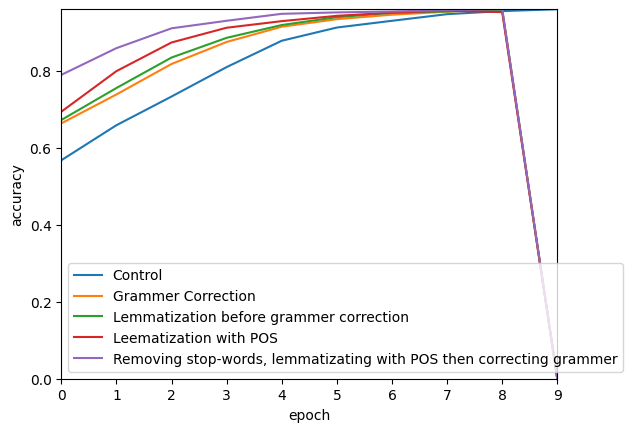

['9.59e-01', '0.00e+00', '0.00e+00', '0.00e+00', '0.00e+00']


In [132]:
control_accuracy = np.array(control_history["accuracy"])
experiment_4_accuracy = np.array(experiment_4_history["accuracy"])
experiment_4_1_accuracy = np.array(experiment_4_1_history["accuracy"])
experiment_4_2_accuracy = np.array(experiment_4_2_history["accuracy"])
experiment_4_3_accuracy = np.array(experiment_4_3_history["accuracy"])

max_length = max(len(control_accuracy), len(experiment_4_accuracy), len(experiment_4_1_accuracy), len(experiment_4_2_accuracy), len(experiment_4_3_accuracy))

control_accuracy_padded = np.pad(control_accuracy, (0, max_length - len(control_accuracy)), mode='constant')
experiment_4_accuracy_padded = np.pad(experiment_4_accuracy, (0, max_length - len(experiment_4_accuracy)), mode='constant')
experiment_4_1_accuracy_padded = np.pad(experiment_4_1_accuracy, (0, max_length - len(experiment_4_1_accuracy)), mode='constant')
experiment_4_2_accuracy_padded = np.pad(experiment_4_2_accuracy, (0, max_length - len(experiment_4_2_accuracy)), mode='constant')
experiment_4_3_accuracy_padded = np.pad(experiment_4_3_accuracy, (0, max_length - len(experiment_4_3_accuracy)), mode='constant')

plot_graphs([control_accuracy_padded, experiment_4_accuracy_padded, experiment_4_1_accuracy_padded, experiment_4_2_accuracy_padded, experiment_4_3_accuracy_padded], name="accuracy", legend=["Control", "Grammer Correction", "Lemmatization before grammer correction", "Leematization with POS", "Removing stop-words, lemmatizating with POS then correcting grammer"])

# Val Accuracy

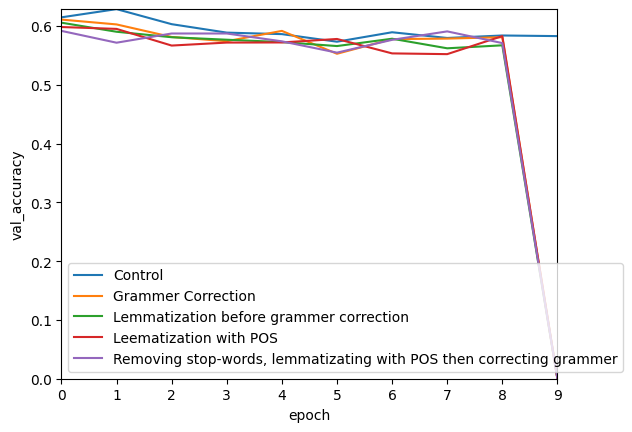

['5.83e-01', '0.00e+00', '0.00e+00', '0.00e+00', '0.00e+00']


In [133]:
control_val_accuracy = np.array(control_history["val_accuracy"])
experiment_4_val_accuracy = np.array(experiment_4_history["val_accuracy"])
experiment_4_1_val_accuracy = np.array(experiment_4_1_history["val_accuracy"])
experiment_4_2_val_accuracy = np.array(experiment_4_2_history["val_accuracy"])
experiment_4_3_val_accuracy = np.array(experiment_4_3_history["val_accuracy"])

max_length = max(len(control_val_accuracy), len(experiment_4_val_accuracy), len(experiment_4_1_val_accuracy), len(experiment_4_2_val_accuracy), len(experiment_4_3_val_accuracy))

control_val_accuracy_padded = np.pad(control_val_accuracy, (0, max_length - len(control_val_accuracy)), mode='constant')
experiment_4_val_accuracy_padded = np.pad(experiment_4_val_accuracy, (0, max_length - len(experiment_4_val_accuracy)), mode='constant')
experiment_4_1_val_accuracy_padded = np.pad(experiment_4_1_val_accuracy, (0, max_length - len(experiment_4_1_val_accuracy)), mode='constant')
experiment_4_2_val_accuracy_padded = np.pad(experiment_4_2_val_accuracy, (0, max_length - len(experiment_4_2_val_accuracy)), mode='constant')
experiment_4_3_val_accuracy_padded = np.pad(experiment_4_3_val_accuracy, (0, max_length - len(experiment_4_3_val_accuracy)), mode='constant')

plot_graphs([control_val_accuracy_padded, experiment_4_val_accuracy_padded, experiment_4_1_val_accuracy_padded, experiment_4_2_val_accuracy_padded, experiment_4_3_val_accuracy_padded], name="val_accuracy", legend=["Control", "Grammer Correction", "Lemmatization before grammer correction", "Leematization with POS", "Removing stop-words, lemmatizating with POS then correcting grammer"])